Tutorial on Numerical Bayesian Techniques
==============

***2022 VIPER Summer School on PTA GW Astrophysics (07/14/2022)***

**Author:** *Bence Bécsy*

<img src="mcmc.png" alt="mcmc" width="300"/>

## Install and import

In [1]:
#If something is not installed try uncommenting these
#!pip install emcee
#!pip install corner

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
# %load_ext line_profiler
# %load_ext snakeviz
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import corner
import emcee
import time

## Setup

### Signal model

We will work with a dataset with a sinusoidal signal in it. So our signal model is:

$$s_i = A \cos (2\pi f t_i - \phi)$$

where $t_i$ are the discrete observation times, and our three model parameters are:

- $A$: Amplitude
- $f$: Frequency
- $\phi$: Initial phase

So in code, our model looks like:

In [3]:
def sineWave(t, A, f, phi):
    return A*np.cos(2*np.pi*f*t - phi)

We create our dataset as a sum of a signal and Gaussian random noise:

$$d_i = s_i + n_i$$

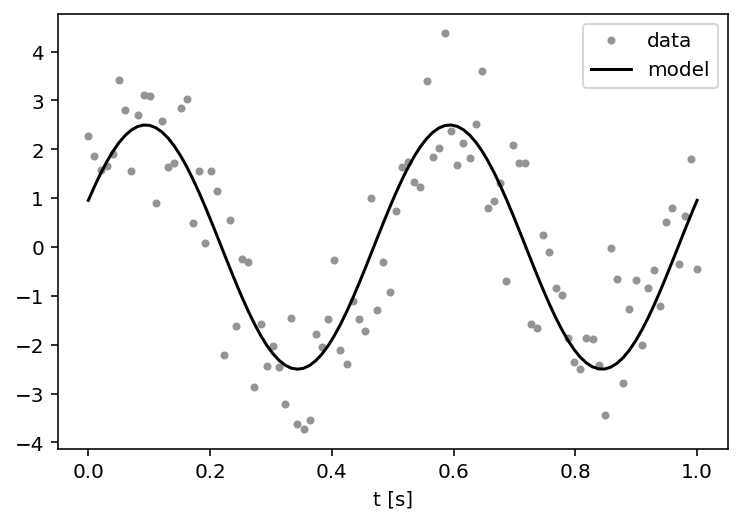

In [4]:
#Set the true parameters of the signal
A0 = 2.5
f0 = 2.0 #Hz
phi0 = 3/8*np.pi

#Set up observation times
t = np.linspace(0,1, 100)

#generate data
d = sineWave(t, A0, f0, phi0) + np.random.normal(0, 1, 100)

#plot data and signal
plt.plot(t, d, color='xkcd:gray', ls='', marker='.', label='data')
plt.plot(t, sineWave(t, A0, f0, phi0), color='xkcd:black', ls='-', label='model')

plt.xlabel("t [s]")

plt.legend()

To carry out Bayesian data analysis, we need a prior, $p(\theta)$, and a likelihood function, $p(d|\theta)$. With these, we can get the posterior as:

$$p(\theta|d) \propto p(d|\theta) p(\theta)$$

### Prior

In this example we use a simple uniform prior on the parameters, so the prior is:

$$p(\theta) = \begin{cases} 0 \ \mathrm{if} \ \theta \ \mathrm{is \ outside \ the \ prior \ volume} \\ (\Delta A  \Delta f  \Delta \phi)^{-1} \ \mathrm{otherwise} \end{cases} $$

where $\Delta A$, $\Delta f$, $\Delta \phi$ are the prior ranges in our three parameters. In practice, we usually work with the log of the prior, and in code we can write this as:

In [5]:
def get_ln_prior(x):
    #Convert array input into parameters
    A = x[0]
    f = x[1]
    phi = x[2]
    
    #Define lower and upper boundaries of parameters
    A_min = 0.0
    A_max = 5.0
    f_min = 1.0
    f_max = 10.0
    phi_min = 0.0
    phi_max = 2*np.pi
    
    #check if given point is within the prior volume
    if A>A_min and A<A_max and f>f_min and f<f_max and phi>phi_min and phi<phi_max:
        #if yes, return finite prior
        return -np.log(A_max-A_min) -np.log(f_max-f_min) -np.log(phi_max-phi_min)
    else:
        #if not, return minus infinity, which corresponds to prior=0
        return -np.inf

In [6]:
#We can test our prior for a point within the prior volume
x0 = np.array([0.4, 4.0, np.pi])
print(get_ln_prior(x0))
#we also print the manually calculated log prior for comparison
print(np.log(1/5/9/(2*np.pi)))

#and for a point outside the prior range we should get -inf
x0 = np.array([-0.4, 4.0, np.pi])
print(get_ln_prior(x0))

-5.644539556179665
-5.644539556179665
-inf


### Likelihood

The final ingredient we need is the likelihood. The log of the likelihood can be written as:

$$\ln p(\theta|d) = -\frac{1}{2} (d-s|d-s) = (d|s) - \frac{1}{2} (s|s) - \frac{1}{2} (d|d)$$

where $(a|b)$ is the inner product defined for stationary white noise as:

$$(a|b) = \sum_{i=0}^N \frac{a_i b_i}{\sigma^2}$$

where $N$ is the number of observations and $\sigma^2$ is the variance of the noise, which we fix in this example. In code, we can write these as:

In [7]:
def inner_product(a, b):
    #define fixed variance
    sigma = 1.0
    #return the computed inner product
    return np.sum(a*b)/sigma**2
    
def get_ln_likelihood(x, t, d):
    #get parameters from vector
    A = x[0]
    f = x[1]
    phi = x[2]
    
    #calculate the signal based on the input parameter vector and data
    s = sineWave(t, A, f, phi)
    
    #calculate three different inner products
    ss = inner_product(s,s)
    ds = inner_product(d,s)
    dd = inner_product(d,d)
    
    #return the combination of inner products that give the log likelihood
    return ds - 0.5*ss - 0.5*dd

To test our likelihood function, it's worth plotting the likelihood as a function of each parameter while we fix the other two parameters to their true values.

Text(0, 0.5, '$\\log L$')

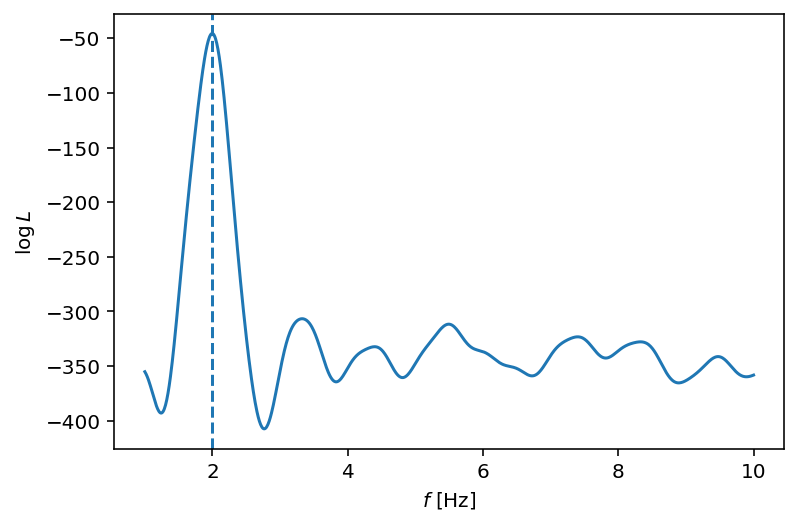

In [8]:
#define grid of frequency values
ff = np.linspace(1,10, 1000)

#calculate likelihood for these frequencies while other parameters are fixed to their true values
logLs = [get_ln_likelihood(np.array([2.5, fff, 3.0/8*np.pi]), t, d) for fff in ff]
plt.plot(ff, logLs)

#mark location of true frequency
plt.gca().axvline(2.0, ls='--')

plt.xlabel(r"$f$ [Hz]")
plt.ylabel(r"$\log L$")

Text(0, 0.5, '$\\log L$')

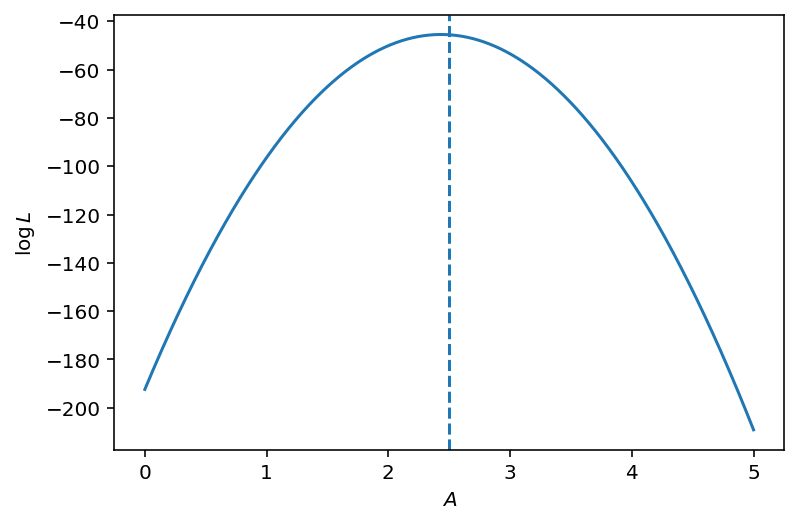

In [9]:
#define grid of frequency values
AA = np.linspace(0,5, 1000)

#calculate likelihood for these frequencies while other parameters are fixed to their true values
logLs = [get_ln_likelihood(np.array([AAA, 2.0, 3.0/8*np.pi]), t, d) for AAA in AA]
plt.plot(AA, logLs)

#mark location of true frequency
plt.gca().axvline(2.5, ls='--')

plt.xlabel(r"$A$")
plt.ylabel(r"$\log L$")

Text(0, 0.5, '$\\log L$')

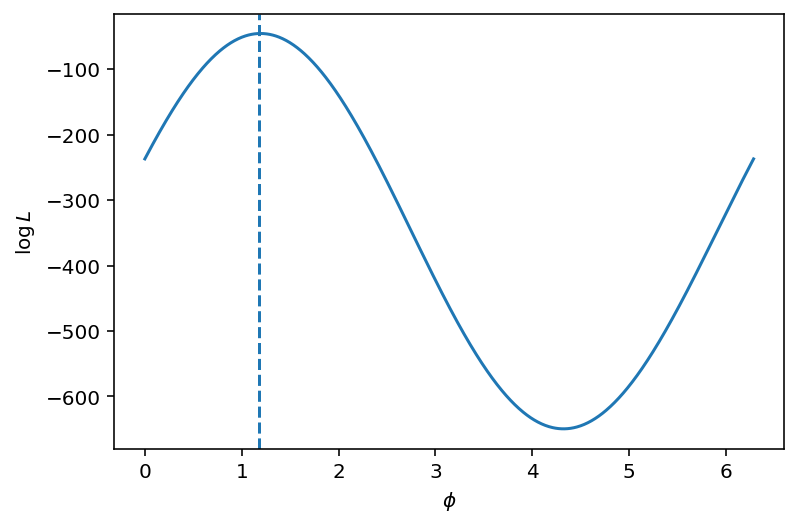

In [10]:
#define grid of frequency values
pphi = np.linspace(0,2*np.pi, 1000)

#calculate likelihood for these frequencies while other parameters are fixed to their true values
logLs = [get_ln_likelihood(np.array([2.5, 2.0, ppphi]), t, d) for ppphi in pphi]
plt.plot(pphi, logLs)

#mark location of true frequency
plt.gca().axvline(3/8*np.pi, ls='--')

plt.xlabel(r"$\phi$")
plt.ylabel(r"$\log L$")

## MCMC (Metropolis–Hastings algorithm)

### Implement and run MCMC

In [ ]:
x_test = np.random.uniform([0, 1, 0], [5, 10, 2 * np.pi], size=(1000, 3)).T
Cov_test = np.cov(x_test)

In [63]:
x_test.shape

(3, 1000)

In [ ]:
w, v = np.linalg.eig(Cov_test)
eig = np.sqrt(w) * v

In [29]:
w, v

(array([1.97560812, 3.29398491, 6.97555077]),
 array([[-0.97786536, -0.20816751, -0.02110994],
        [-0.02900849,  0.03496346,  0.9989675 ],
        [ 0.2072145 , -0.97746808,  0.04022818]]))

In [30]:
np.sqrt(w[0])*v[:,0]

array([-1.37445163, -0.04077327,  0.29125309])

In [34]:
eig = (np.sqrt(w) * v).T

In [97]:
np.linalg.eig(np.cov(np.random.uniform([0, 1, 0], [5, 10, 2 * np.pi], size=(100, 3)).T))

(array([1.95590131, 6.26186418, 3.54191587]),
 array([[-0.99338973, -0.08466502, -0.07751567],
        [-0.06544052,  0.97249413, -0.22354575],
        [-0.09431004,  0.21699538,  0.97160621]]))

In [107]:
def run_mcmc(Cov, N, t, d):
    """MCMC Routine
    
    Inputs:
    Cov -- Covariance matrix to use for proposal
    N   -- Number of iterations to run for
    t   -- Observation times of data
    d   -- Data
    
    Returns:
    samples      -- Posterior samples in an (N, 3) array
    acc_fraction -- Fraction of steps accepted for each eigendirection in a length 3 array
    log_like     -- Log likelihood values corresponding to the posterior samples in a length N array
    """
    
    # Find eigenvectors and eigenvalues of covariance matrix to use for proposal    
    # Form vectors we will jump along by scaling the eigenvectors by the sqrt of the eigenvalues
    w, v = np.linalg.eig(Cov)
    eig = (np.sqrt(w) * v).T
    
    # print them
    print(eig)
    
    #initiate arrays to hold posterior samples and log likelihood values
    samples = np.zeros((int(N),3))
    log_like = np.zeros(int(N))
    
    # Define first point to start from and add its likelihood to likelihood array
    # We can start from a predefined point, or
    # from one randomly drawn from the prior (better idea)
    samples[0] = np.random.uniform([0, 1, 0], [5, 10, 2 * np.pi])
    log_like[0] = get_ln_likelihood(samples[0], t, d)
    
    #Set up arrays to track acceptance rate (1 element for each parameter)
    #track acceptances in a_yes and rejection in a_no
    a_yes=np.array([0,0,0])
    a_no=np.array([0,0,0])
    
    #main loop over iterations
    for i in range(int(N-1)):
        #print iteration number 10 times during the run
        if i % int(N / 10) == 0:    
            print(i)
        
            # update the covariance matrix using all the previous samples
            # every 100 iterations as well
            # Cov = np.cov(samples.T)
            # w, v = np.linalg.eig(Cov)
            # eig = (np.sqrt(w) * v).T
        
        #Randomly select which eigendirection to jump in
        j = np.random.choice([0, 1, 2])
        jump = eig[j]

        #Next proposed point is
        #the current point plus the eigen vector chosen above times a unit normal random number
        new_point = samples[i] + jump * np.random.normal()
        
        #Get log likelihood of new point
        log_L = get_ln_likelihood(new_point, t, d)
        
        #Calculate the acceptance probability as the exponentiated
        #difference in log likelihood and difference in log prior
        acc_ratio = np.exp(log_L - log_like[i] + get_ln_prior(new_point) - get_ln_prior(samples[i]) )

        #Draw random number from (0,1) and compare with acceptance probability
        #to decide if we accept or reject the proposal
        #Add appropriate values to samples and log_like depending on the result
        #Also track accptance with a_yes/a_no
        # u = np.random.uniform(0, 1)
        if np.random.uniform() <= acc_ratio:
            samples[i + 1] = np.copy(new_point)
            log_like[i + 1] = np.copy(log_L)
            a_yes[j] += 1
        else:
            samples[i + 1] = np.copy(samples[i])
            log_like[i + 1] = np.copy(log_like[i])
            a_no[j] += 1

    #Calculate the fraction of accepted steps
    acc_fraction = a_yes/(a_no+a_yes)
    #return the samples, the fraction of accepted steps, and the array of log likelihood values
    return samples, acc_fraction, log_like

In [108]:
# #solution
# def run_mcmc(Cov, N, t, d):
#     """MCMC Routine
    
#     Inputs:
#     Cov -- Covariance matrix to use for proposal
#     N   -- Number of iterations to run for
#     t   -- Observation times of data
#     d   -- Data
    
#     Returns:
#     samples      -- Posterior samples in an (N, {number of parameters}) array
#     acc_fraction -- Fraction of steps accepted for each eigendirection in a {number of parameters} length array
#     log_like     -- Log likelihood values corresponding to the posterior samples
#                     in a {number of parameters} length array
#     """
    
#     #Find eigenvectors and eigenvalues of covariance matrix to use for proposal
#     w, v = np.linalg.eig(Cov)
    
#     #Form vectors we will jump along by scaling the eigenvectors by the sqrt of the eigenvalues
#     eig1 = np.sqrt(w[0])*v[:,0]
#     eig2 = np.sqrt(w[1])*v[:,1]
#     eig3 = np.sqrt(w[2])*v[:,2]
#     print(eig1,eig2,eig3)
    
#     #initiate arrays to hold posterior samples and log likelihood values
#     samples = np.zeros((int(N),3))
#     log_like = np.zeros(int(N))
    
#     #Define first point to start from and add its likelihood to likelihood array
#     #samples[0,:] = np.array([0.5,5.0,2.0])
#     #Draw from prior to set first point
#     samples[0,0] = np.random.uniform(0,5)
#     samples[0,1] = np.random.uniform(1,10)
#     samples[0,2] = np.random.uniform(0,2*np.pi)
        
#     log_like[0] = get_ln_likelihood(samples[0,:], t, d)
    
#     #Set up arrays to track acceptance rate
#     a_yes=np.array([0,0,0])
#     a_no=np.array([0,0,0])
    
#     #main loop over iterations
#     for i in range(int(N-1)):
#         #print iteration number 10 times during the run
#         if i%int(N/10)==0:    
#             print(i)

#         #Randomly select which eigendirection to jump in
#         jump_select = np.random.choice(3)
#         if jump_select==0:
#             jump=eig1
#         elif jump_select==1:
#             jump=eig2
#         elif jump_select==2:
#             jump=eig3

#         #Next proposed point is the current point plus the jump defined above times a unit normal random number
#         new_point = samples[i,:] + jump*np.random.normal()
#         #Get log likelihood of new point
#         log_L = get_ln_likelihood(new_point, t, d)
        
#         #Calculate the acceptance probability as the exponentiated
#         #difference in log likelihood and difference in log prior
#         acc_ratio = np.exp(log_L- log_like[i] + get_ln_prior(new_point) - get_ln_prior(samples[i,:]) )

#         #Draw random number to decide if we accept or reject the proposal
#         if np.random.uniform()<=acc_ratio: #accept 
#             #copy new point to the necxt slice of samples
#             samples[i+1,:] = np.copy(new_point)
#             #save new likelihood value
#             log_like[i+1] = log_L
#             #record an acceptance
#             a_yes[jump_select]+=1
#         else: #reject
#             #copy previous sample to new slice
#             samples[i+1,:] = np.copy(samples[i,:])
#             #copy old likelihood
#             log_like[i+1] = log_like[i]
#             #record rejection
#             a_no[jump_select]+=1

#     #Calculate the fraction of accepted steps
#     acc_fraction = a_yes/(a_no+a_yes)
#     #return the samples, the fraction of accepted steps, and the array of log likelihood values
#     return samples, acc_fraction, log_like

In [109]:
%%time

#Define the covaraince matrix
Cov = np.array([[0.1, 0., 0.],[0., 0.01, 0.],[0., 0., 0.1]])

#run sampler
samples, acc_fraction, log_like = run_mcmc(Cov, 5e5, t, d)

[[0.31622777 0.         0.        ]
 [0.         0.1        0.        ]
 [0.         0.         0.31622777]]
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
CPU times: user 30.2 s, sys: 1.51 s, total: 31.7 s
Wall time: 30.5 s


### Postprocessing

In [110]:
#Print the fraction of accepted steps
#should be around 0.2-0.3, but definitely >0.1 and <0.9
print(acc_fraction)

[0.46196839 0.2239376  0.24946771]


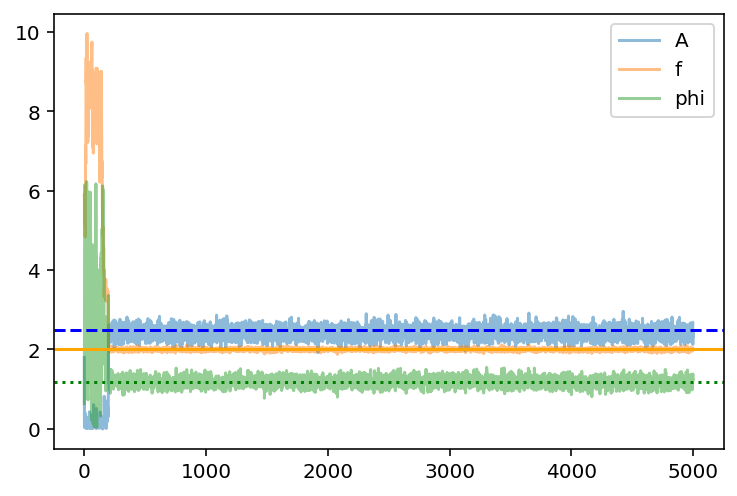

In [111]:
#Make "trace plots", i.e. plot the parameters as a function of iterations
#We want to see "fuzzy caterpillars", i.e. chains randomly moving around a mean value with no longterm structure
#Usually sampler takes some time to find a stationary solution
#The samples before this happens are called "burn-in" an we typically cut them before analyzing the samples
#We can also plot truth values of the parameters to see if the samples converge to that
labels = ["A", "f", "phi"]
for i,lab in enumerate(labels):
    plt.plot(samples[::100, i], label=lab, alpha=0.5)

plt.gca().axhline(2.5, ls='--', color='blue')
plt.gca().axhline(2, ls='-', color='orange')
plt.gca().axhline(3/8*np.pi, ls=':', color='green')

plt.legend()

In [60]:
#The samples we get from an MCMC are not independent
#So it is also useful to calculate the autocorrelation length of the chains
#We want to keep these as low as possible, so that we get as many independent samples as possible for given N
#This can also help diagnose which parameters are sampled well, and which need more tuning
cc1 = emcee.autocorr.integrated_time(samples[20000::10,0], c=1, quiet=True)
cc2 = emcee.autocorr.integrated_time(samples[20000::10,1], c=1, quiet=True)
cc3 = emcee.autocorr.integrated_time(samples[20000::10,2], c=1, quiet=True)

print(cc1, cc2, cc3)

[72.84466134] [100.4716362] [12.99799518]


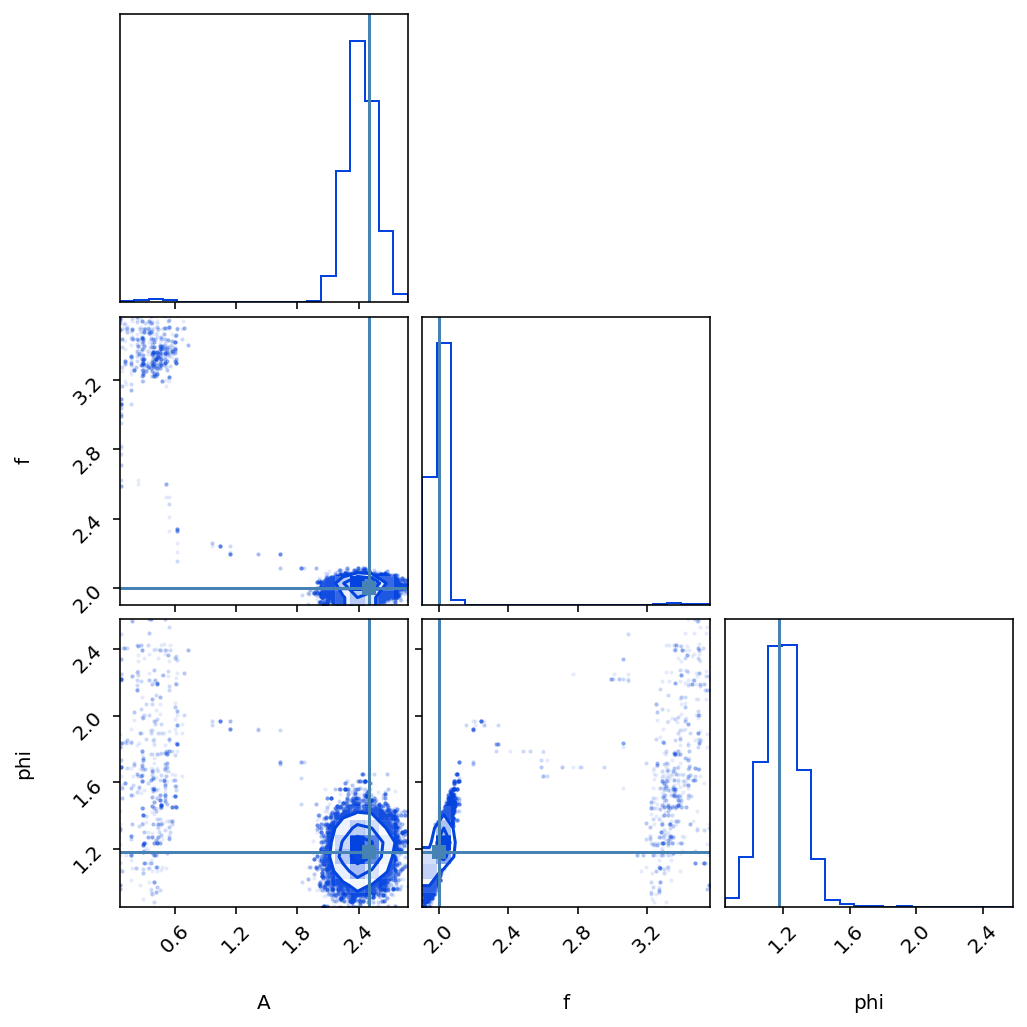

In [61]:
#A very common way of visalizing multi-dimensional posteriors is to make a so-called corner plot
#This shows plots on a {# of parameters}x{# of parameters} grid
#With 1D marginal distributions on the diagonal
#And 2D marginal distributions of each parameter pair on the off-diagonal elements

#Labels to use on the plot
labels = ["A", "f", "phi"]

#Range of the plots for each parameter
#Can be defined as a fraction of points to contain, or as an actiual range between two parameter values
ranges = [0.999,0.999,0.999]
#ranges = [(3.5,6.5),(4.8,5.2),(1.5/8*np.pi,4.5/8*np.pi)]
#ranges = [(0,5),(1,10),(0,2*np.pi)]

#Truth values to overplot
truth = [A0,f0,phi0]

#Number of burnin parameters to discard at the start
burnin = 20_000

fig = corner.corner(samples[burnin:,:], labels=labels, range=ranges, color='xkcd:blue',
                    truths=truth, hist_kwargs={"density":True})

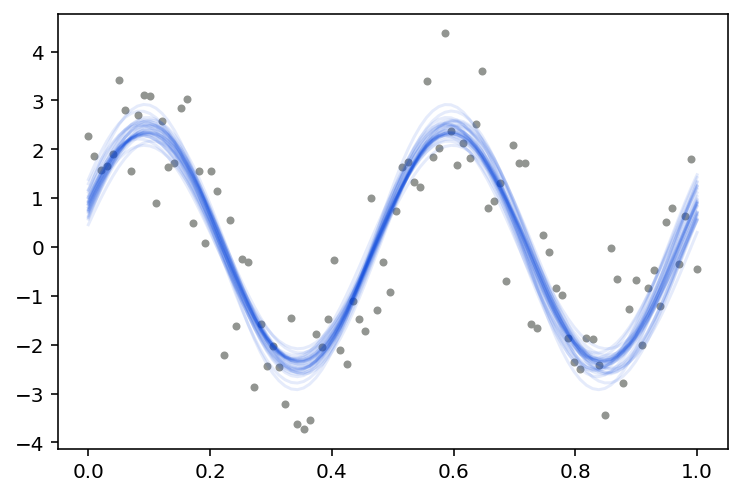

In [62]:
#Another useful way to visualize the result is to create a Bayesogram
#This shows the distribution of the signal itself instead of the parameters
#We can do this by plotting the signal for randomly drawn parameters from the posterior
#This also provides a good sanity check to see if we have good agreement with the data

#Plot the data
plt.plot(t, d, color='xkcd:gray', ls='', marker='.', label='data')

#Number of posterior points to use
NN = 30
#Loop over random posterior samples
for i in range(NN):
    #Randomly pick a posterior sample (excluding the burnin)
    idx = np.random.choice(samples.shape[0]-burnin)
    #Plot tha signal model for that posterior sample
    plt.plot(t, sineWave(t, samples[burnin+idx,0], samples[burnin+idx,1], samples[burnin+idx,2]),
             color='xkcd:blue', ls='-', alpha=0.1)

17.6150586518692


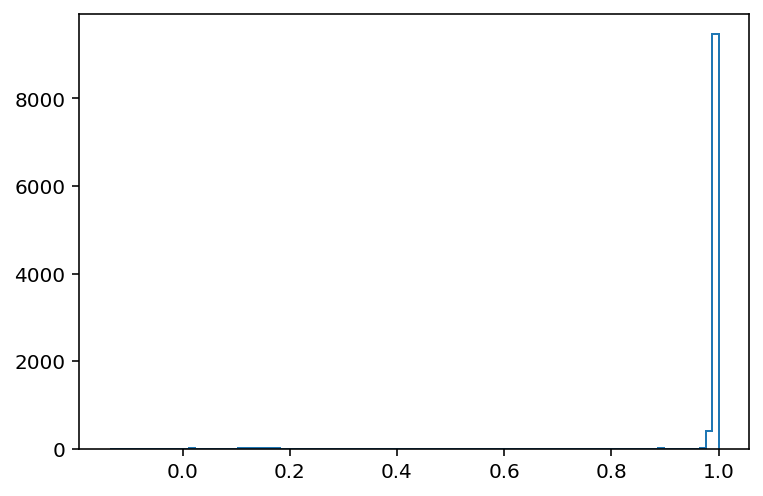

In [67]:
#Another thing worth checking is the match between the true signal and the recovered signal defined as
# M = (h'|h)/sqrt((h|h)*(h'|h')) where h is the injected signal and h' is the recovered signal

#get injected signal
h = sineWave(t, 2.5, 2, 3/8*np.pi)

#Also worth calculating the SNR of the injected signal
SNR = np.sqrt(inner_product(h,h))
print(SNR)

#Number of posterior points to use
NN = 10_000

#array to hold match values
Ms = np.zeros(NN)

#Loop over random posterior samples
for i in range(NN):
    #Randomly pick a posterior sample (excluding the burnin)
    idx = np.random.choice(samples.shape[0]-burnin)
    #get waveform for this sample
    h_p = sineWave(t, samples[burnin+idx,0], samples[burnin+idx,1], samples[burnin+idx,2])
    #Plot tha signal model for that posterior sample
    Ms[i] = inner_product(h,h_p)/np.sqrt(SNR**2 * inner_product(h_p,h_p))

_ = plt.hist(Ms, bins=100, histtype='step')

16.016016016016017


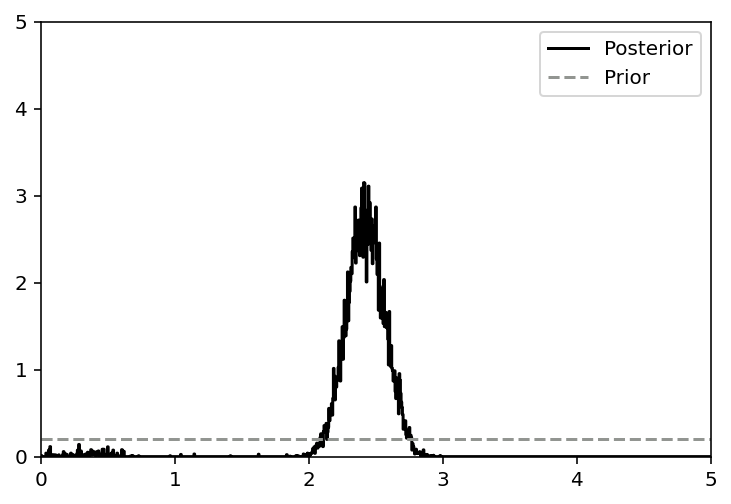

In [68]:
#We can also estimate the Bayes factor for the presence of this sinusoidal signal
#using the Savage-Dickey density ratio, which approximates the Bayes factor as the
#ratio of the prior and posterior at zero amplitude
#we can approximate this by making a hostogram of the amplitude distribution and 
#comparing the value at the lowest bin to the prior
#
#Note that if the signal is very strong we may not have any samples at the lowest bin
#and thus we cannot directly calculate the Bayes factor
#(we can do follow-up runs zoomed in at low amplitudes and get Bayes factors after an iterative process)

#get amplitude posterior values
As = samples[burnin:,0]
#define linear bins on the whole prior range
Bins = np.linspace(0, 5, 1000)

#Make histogram of amplitudes
hist, bin_edges = np.histogram(As, bins=Bins, density=True)

#Plot the amplitude posterior and prior
plt.step(bin_edges[:-1], hist, where='post', label='Posterior', color='xkcd:black')
plt.gca().axhline(1/5, label='Prior', ls='--', color='xkcd:grey')

plt.legend()

plt.xlim(0,5.0)
plt.ylim(0,5)

#print out the estimate of the Bayes factor
print((1/5)/hist[0])

## Ideas to try

- Play around with different parameters of the signal (e.g. weak/marginal signal, higher/lower frequency, etc.)
- Try to analyze a dataset with no noise. How are the results different from the ones with noise?
- Produce the posterior distribution of SNR anc compare to the injected SNR.
- Try to find a covariance matrix that minimizes the autocorrelation lengths (Hint: try approximating it from the posteriors of a pilot run)
- Allow the noise level to vary in our model and sample that with the MCMC as well
- Add different proposals to your MCMC. A draw from the prior should be easy. Differential evolution or a global proposal (e.g. in frequency based on the PSD of the data) would be a more challenging task.
- Try adding parallel tempering to your MCMC